<a href="https://colab.research.google.com/github/DMTX2410/TL-P1/blob/main/Modelo_para_predecir_la_lluvia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importamos las librerias
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout

In [ ]:
#Se carga el archivo que contiene los datos
filepath = "https://raw.githubusercontent.com/DMTX2410/TL-P1/main/seattleWeather_1948-2017.csv" #Se guarda la ruta en la variable filepath
df = pd.read_csv(filepath) #Se asignan los datos de la ruta a la variable df

In [ ]:
#Se convierte la columna de lluvia a valores enteros y se guardan en una nueva columna "rain"
df['rain']=[1 if i==True else 0 for i in df['RAIN']] #Definimos como 1 si el valor es verdadero y como 0 si el valor es falso.

In [ ]:
#Se eliminan los valores nulos
df.dropna(inplace=True) # El metodo dropna permite filtrar los valores de una estructura de datos pandas para dejar solo aquellos no nulos.

In [ ]:
#Definimos X y Y
x = df[['PRCP', 'TMAX', 'TMIN']] #Aqui definimos que solo estas 3 columnas se guardaran en x
y = df['rain'] #rain al ser el valor con el cual se valida, se guarda en Y

In [ ]:
#Se definen las variables de entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)#Se deja un tamaño de entrenamiento del 80%

In [ ]:
#Usamos el modelo secuencial de Keras
def build_model(): #Se define como función
  model = keras.Sequential()
  #Se usa una función de activacion de tipo relu, debido a la eficacia de esta en este tipo de casos
  model.add(keras.layers.Dense(64, activation='relu', input_dim=x.shape[1]))#La capa de entrada tendra un total de 64 neuronas
  model.add(keras.layers.Dense(32, activation='relu'))#La capa oculta tendra un total de 32 neuronas
  model.add(keras.layers.Dense(1, activation='sigmoid'))#La capa de salida tendra solo una, la función de activación sera de tipo sigmoide debido al tipo de capa.
  model.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy'])
  #Se especifica la forma como se calcularán los parámetros de la línea recta (w y b). 
  #Para ello se utiliza adam como modelo de optimizacion y crossentropy para determinar los pesos mediante backpropagation
  return model

In [ ]:
#Detalles del modelo
model = build_model()#Instanciamos el modelo
model.summary()#Nos permite ver los parametros del modelo

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                256       
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos la red neuronal
history = model.fit(x_train, y_train, batch_size=10, epochs=10,validation_split =0.2,verbose=2)
#Le asignamos un batch de 10 y epocas de 10, esto con el fin de obtener una precision alta a menor cantidad de epocas.
#Para la validacion utilizaremos el 20% de las pruebas. 

Epoch 1/10
1635/1635 - 4s - loss: 0.5025 - accuracy: 0.7563 - val_loss: 0.3944 - val_accuracy: 0.8165 - 4s/epoch - 3ms/step
Epoch 2/10
1635/1635 - 4s - loss: 0.3763 - accuracy: 0.8220 - val_loss: 0.3539 - val_accuracy: 0.8312 - 4s/epoch - 3ms/step
Epoch 3/10
1635/1635 - 4s - loss: 0.3080 - accuracy: 0.8634 - val_loss: 0.2417 - val_accuracy: 0.9031 - 4s/epoch - 2ms/step
Epoch 4/10
1635/1635 - 5s - loss: 0.2467 - accuracy: 0.8976 - val_loss: 0.1922 - val_accuracy: 0.9300 - 5s/epoch - 3ms/step
Epoch 5/10
1635/1635 - 4s - loss: 0.2104 - accuracy: 0.9204 - val_loss: 0.1655 - val_accuracy: 0.9369 - 4s/epoch - 3ms/step
Epoch 6/10
1635/1635 - 4s - loss: 0.1767 - accuracy: 0.9354 - val_loss: 0.1297 - val_accuracy: 0.9477 - 4s/epoch - 2ms/step
Epoch 7/10
1635/1635 - 5s - loss: 0.1397 - accuracy: 0.9509 - val_loss: 0.1070 - val_accuracy: 0.9535 - 5s/epoch - 3ms/step
Epoch 8/10
1635/1635 - 4s - loss: 0.1243 - accuracy: 0.9583 - val_loss: 0.1770 - val_accuracy: 0.9469 - 4s/epoch - 3ms/step
Epoch 9/

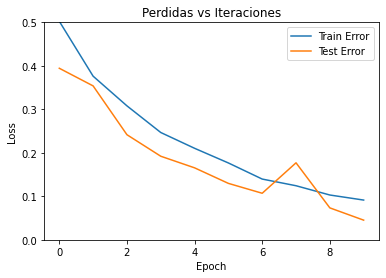

In [ ]:
#Grafica de perdidas vs iteraciones
hist = pd.DataFrame(history.history)#Extraemos los datos del entrenamiento y validación
hist['epoch'] = history.epoch #Asignamos el valor de las epocas
plt.figure() #Creamos la figura
plt.xlabel('Epoch')#Se asigna el nombre del ehe x
plt.ylabel('Loss')#Se asigna el nombre del ehe y
plt.title('Perdidas vs Iteraciones')#Se asigna el nombre del titulo de la grafica
plt.plot(hist['epoch'], hist['loss'], label = 'Train Error')#Graficamos los valores de entrenamiento
plt.plot(hist['epoch'], hist['val_loss'], label = 'Test Error')#Graficamos los valores de validacion
plt.ylim(0,0.5)#Definimos los limites de y
plt.legend()#Ploteamos los nombres de las graficas


In [ ]:
prediction_nn = model.predict(x_test) #Usamos la funcion de predict sobre la variable de test
prediction_nn = [1 if y>=0.5 else 0 for y in prediction_nn]#Definimos los parametros
print(classification_report(y_test, prediction_nn))#Imprimos los datos

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2953
           1       1.00      0.89      0.94      2157

    accuracy                           0.95      5110
   macro avg       0.96      0.95      0.95      5110
weighted avg       0.96      0.95      0.95      5110

